# Bicicletas

In [1]:
import pandas as pd

dados = pd.read_csv('day.csv')
dados.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


# Que informações nós temos?

In [2]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Temperatura')

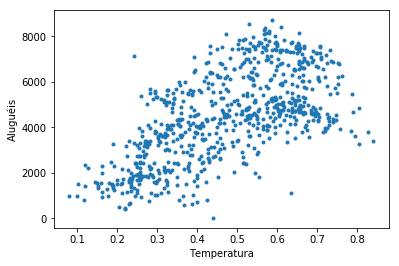

In [3]:
plt.plot(dados['atemp'],dados['cnt'],'.')
plt.ylabel('Aluguéis')
plt.xlabel('Temperatura')

Text(0.5, 0, 'Humidade')

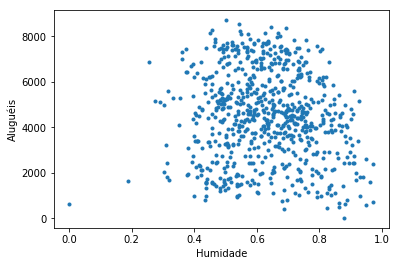

In [4]:
plt.plot(dados['hum'],dados['cnt'],'.')
plt.ylabel('Aluguéis')
plt.xlabel('Humidade')

Text(0.5, 0, 'Velocidade do Vento')

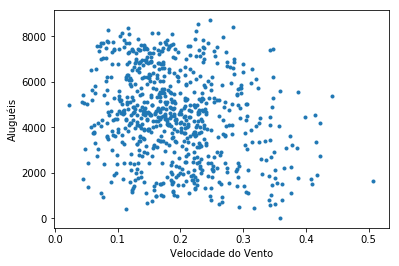

In [5]:
plt.plot(dados['windspeed'],dados['cnt'],'.')
plt.ylabel('Aluguéis')
plt.xlabel('Velocidade do Vento')

Text(0.5, 0, 'Situação do tempo')

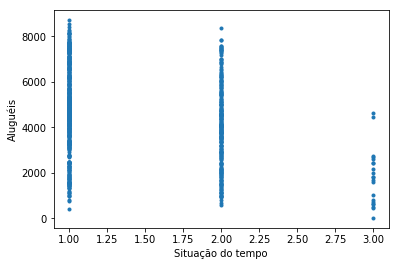

In [6]:
plt.plot(dados['weathersit'],dados['cnt'],'.')
plt.ylabel('Aluguéis')
plt.xlabel('Situação do tempo')

## Defindo com quais dados vamos trabalhar

In [7]:
import numpy as np

In [8]:
y = np.asarray(dados['cnt']) #Alvo

# Indo para frente

<img src="fazer">

## Estrutura da Rede

In [9]:
arquitetura = [
    {"entrada": 2, "saida": 4, "ativacao": "relu"},
    {"entrada": 4, "saida": 4, "ativacao": "relu"},
    {"entrada": 4, "saida": 1, "ativacao": "linear"},
]

## Camada de Entrada

In [10]:
X = np.asarray(dados[['weathersit','atemp']])
print(X)

[[2.       0.363625]
 [2.       0.353739]
 [1.       0.189405]
 ...
 [2.       0.2424  ]
 [1.       0.2317  ]
 [2.       0.223487]]


## Pesos

In [11]:
def inicia_camadas(arquitetura, seed = 99):
    np.random.seed(seed)
    numero_de_camadas = len(arquitetura)
    valores_parametros = {}

    for indice_camada, camada in enumerate(arquitetura):
        camada_i = indice_camada + 1
        tamanho_entrada = camada["entrada"]
        tamanho_saida = camada["saida"]
        
        valores_parametros['P' + str(camada_i)] = np.random.randn(
            tamanho_saida, tamanho_entrada) * 0.1
        valores_parametros['b' + str(camada_i)] = np.random.randn(
            tamanho_saida, 1) * 0.1
        
    return valores_parametros

In [12]:
valores_parametros = inicia_camadas(arquitetura)

In [13]:
print(valores_parametros)

{'P1': array([[-0.01423588,  0.20572217],
       [ 0.02832619,  0.1329812 ],
       [-0.01546219, -0.00690309],
       [ 0.07551805,  0.08256466]]), 'b1': array([[-0.01130692],
       [-0.23678376],
       [-0.01670494],
       [ 0.0685398 ]]), 'P2': array([[ 0.00235001,  0.04562013,  0.02704928, -0.14350081],
       [ 0.08828171, -0.05800817, -0.05015653,  0.05909533],
       [-0.07316163,  0.02617555, -0.08557956, -0.01875259],
       [-0.03734863, -0.0461971 , -0.08164661, -0.00451233]]), 'b2': array([[ 0.01213278],
       [ 0.09259528],
       [-0.05738197],
       [ 0.00527031]]), 'P3': array([[0.22073106, 0.03918219, 0.04827134, 0.0433334 ]]), 'b3': array([[-0.17042917]])}


## Funções de ativação

In [14]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))


def relu(Z):
    return np.maximum(0,Z)

def linear(Z):
    return Z

## Foward Propagation

In [15]:
def propaga_uma_camada(A_ant, P_atual, b_atual, ativacao='relu'):
    
    Z_atual = np.dot(P_atual, A_ant) + b_atual
    
    if ativacao is 'relu':
        ativa = relu
    else:
        ativa = linear
        
    return Z_atual, ativa(Z_atual)

\begin{equation}
    z^{[l]} = P^{[l]}.a^{[l-1]} + b^{[l]}
\end{equation}

In [16]:
def propagacao_total(X, valores_parametros, arquitetura):
    
    A_atual = X
    memoria = {}
    
    for indice_camada, camada in enumerate(arquitetura):
        camada_i = indice_camada + 1
        A_anterior = A_atual
        
        ativacao_atual = camada["ativacao"]
        P_atual = valores_parametros["P" + str(camada_i)]
        b_atual = valores_parametros["b" + str(camada_i)]
        A_atual, Z_atual = propaga_uma_camada(A_anterior, P_atual, b_atual, ativacao_atual)
        
        memory["A" + str(indice_camada)] = A_anterior
        memory["Z" + str(camada_i)] = Z_atual
       
    return A_atual, memoria

## Medindo o erro - Loss function

In [17]:
def mean_squared_error(y_verdadeiro, y_predito):
    m = y_verdadeiro.shape[1]
    MSE = (1/m)*np.power(y_verdadeiro-y_predito,2)
    return MSE

# Retropropagação - Backward propagation

In [1]:
def linear_retro(dA, Z):
    dZ=dA
    return dZ


def relu_retro(dA, Z):
    dZ = np.array(dA, copy= True)
    dZ[Z <= 0] = 0
    return dZ;

In [2]:
def retropropagacao_uma_camada(dA_atual, P_atual, b_atual, Z_atual, A_anterior, ativacao='relu'):
    
    m = A_anterior.shape[1]
    
    if ativacao is 'relu':
        ativacao_retro = relu_retro
    else:
        ativacao_retro = linear_retro
        
    dZ_atual = ativacao_retro(dA_atual, Z_atual)
    dP_atual = np.dot(dZ_atual, A_anterior.T) / m
    db_atual = np.sum(dZ_atual, axis=1, keepdims=True) / m
    dA_prev = np.dot(P_atual.T, dZ_atual)
    
    return dA_anterior, dP_atual, db_atual

In [3]:
##Equações

In [4]:
def retropropagacao_total(y_verdadeiro, y_predito, memoria, valores_parametros, arquitetura):
    
    valores_gradiente = {}
    m = y_predito.shape[1]
    y_predito = y_predito.reshape(y_verdadeiro.shape)
    
    dA_anterior = -(np.divide(y_verdadeiro - y_predito) -np.divide(1 - y_verdadeiro, 1 - y_predito))
    
    for indice_camada_anterior, camada in reversed(list(enumerate(arquitetura))):
        indice_camada_atual = indice_camada_anterior + 1
        ativacao_atual = layer["ativacao"]
        
        dA_atual = dA_anterior
        
        A_anterior = memoria["A" + str(indice_camada_anterior)]
        Z_atual = memoria["Z" + str(indice_camada_atual)]
        P_atual = valores_parametros["P" + str(indice_camada_atual)]
        b_atual = valores_parametros["b" + str(indice_camada_atual)]
        
        dA_anterior, dP_atual, db_atual = retropropagacao_uma_camada(
        dA_atual, P_atual, b_atual, Z_atual, A_anterior, ativacao_atual)
        
        valores_gradiente["dW" + str(indice_camada_atual)] = dP_atual
        valores_gradiente["db" + str(indice_camada_atual)] = db_atual
        
    return valores_gradiente
        

## Atualizando os valores dos parâmetros

In [5]:
#Equação

In [7]:
def atualiza(valores_parametros, valores_gradiente, arquitetura, taxa_aprendizagem):
    for indice_camada, camada in enumerate(arquitetura):
        valores_parametros["P" + str(indice_camada)] -= taxa_aprendizagem * valores_gradientes["dP" + str(indice_camada)]
        valores_parametros["b" + str(indice_camada)] -= taxa_aprendizagem * valores_gradientes["db" + str(indice_camada)]
        
    return valores_parametros